# D213 - Advanced Data Analytics
### NLM3 Task 1: Time Series Modeling
#### Advanced Data Analytics — D213
#### PRFA — NLM3
> André Davis
> StudentID: 010630641
> MSDA
>
> Competencies
> 4030.7.2 : Time Series Analysis
> The graduate applies time series models in generating forecasts. 

#### Table of Contents
<ul>
    <li><a href="#research-question">A1: Research Question</a></li>
    <li><a href="#objectives">A2: Objectives and Goals of Analysis</a></li>
    <li><a href="#assumptions">B: Assumptions of Time Series Model</a></li>
    <li><a href="#visualizations">C1: Time Series Visualization</a></li>
    <li><a href="#time-step-description">C2: Description of Time Step Formatting</a></li>
    <li><a href="#stationary-of-series">C3: Stationarity of Series</a></li>
    <li><a href="#data-preparation">C4: Data Preparation & Explanation</a></li>
    <li><a href="#copy-of-prepared-data">C5: Copy of Prepared Data Set</a></li>
    <li><a href="#annotated-findings-and-visualizations">D1: Annotated Findings & Visualizations</a></li>
    <li><a href="#arima-model-of-time-series-data">D2: ARIMA Model of Time Series Data</a></li>
    <li><a href="#forcast">D3: Forecast</a></li>
    <li><a href="#analysis">D4: Analysis Output & Calculations</a></li>
    <li><a href="#arima-code">D5: ARIMA Model Code</a></li>
    <li><a href="#results-of-analysis">E1: Results of Analysis</a></li> 
    <li><a href="#forcast-visualizations">E2: Visualization of Forecast</a></li> 
    <li><a href="#recommendations">E3: Recommended Action</a></li>
    <li><a href="#reporting">F: Reporting</a></li>
    <li><a href="#code-references">G: Code References</a></li>
    <li><a href="#source-references">H: Source References</a></li>    
</ul>

# Part I: Research Question

<a id="research-question"></a>
## A1: Research Question

The research question explored in this report is: "Is it possible to accurately and effectively forecast the daily revenues of [`WGU`](https://www.wgu.edu/) Hospital System in a manner that aligns closely with the actual observed daily revenues?"

<a id="objectives"></a>
## A2: Objectives and Goals of Analysis

The objective of this analysis is to accurately predict daily revenues for the [`WGU`](https://www.wgu.edu) Hospital System utilizing the available [`dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip). The analysis employs an 80-20 split of the dataset, using the initial 80% as a training set to forecast the remaining 20%, which serves as a test set. This approach allows for the use of observed values as a benchmark for comparison. An ARIMA time series model will be utilized to analyze the training set and project the values in the test set.

> ARIMA is a "model runs *d* rounds of differencing to make the time series more stationary, then it applies a regular ARMA Model. When making forecasts, it uses this ARMA model, then it adds back the terms that were subtracted by differencing."(Géron, 2022).

# Part II: Method Justification

<a id="assumptions"></a>
## B: Assumptions of Time Series Model

>The submission accurately summarizes each of the assumptions of a time series model. The summary includes stationarity and autocorrelated data.

Assumptions of the ARMA Family of Models, including ARIMA include:

 1. Data must not include outliers and/or anomalies 
 2. The time series data should exhibit stationary, devoid of any trends or seasonal fluctuations.
 3. Datapoints in the past must be indicative of future datapoints in behavior.
 4. The data must reflect a single variable and be classified as uni-variate to be modelled.
 5. The data must be auto-correlated for ARIMA model to perform forecasting via Autoregressive Component 

Some observational notes about the [`WGU Medical Time Series Dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip) and the assumption point #3. Because this is a Performance Assessment for graduate school, the data presented for this activity is pretty limited. There are 730 rows and because this is a daily record, this equals 2 years of daily data. It may or may not be enough information to know if the past data indicates future behavior.

# Part III: Data Preparation

<a id="visualizations"></a>
## C1: Time Series Visualization

In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

medical_daily_revenue = pd.read_csv('./medical_time_series.csv')
medical_daily_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB


In [15]:
'''
For a Time-Series it will be easier to work with actual dates rather than a single number in the span of 2 years.

Because this is an academic performance assessment I will use the start data of Jan 1st 2021. I'm basing this off
the year WGU was founded within "The National Society of Leadership and Success" + 1 year so the 2 year period ends in 2023 (current year of this assignment)

To index with dates pd.date_range (https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) will be used.
'''

date_range_indexes = pd.date_range(start='2021', periods=len(medical_daily_revenue), freq='D')
medical_daily_revenue.set_index(date_range_indexes, inplace=True)
medical_daily_revenue.drop('Day', axis=1, inplace=True)

medical_daily_revenue.info()

print(f'\nTotal Records: [{len(medical_daily_revenue)}]')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-01-01 to 2023-01-01
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB

Total Records: [731]


#### Visualization of the Medical Daily Revenue Dataset

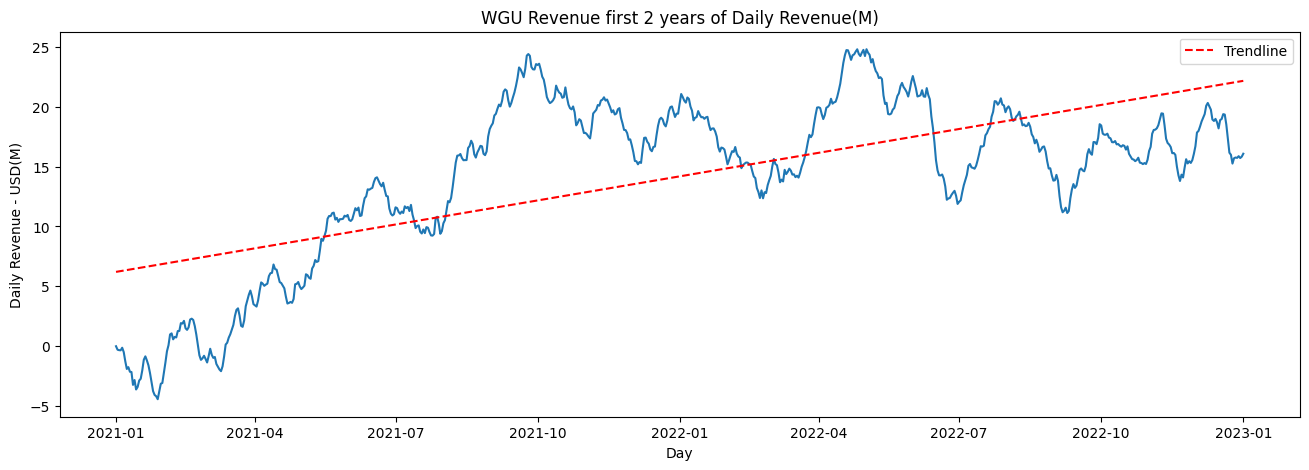

In [16]:
def chart_time_series(x: pd.Series, y: pd.Series, title: str) -> None:
    """
    :param x: x-coordinates data to plot
    :type x: pd.Series
     
    :param y: y-coordinates data to plot
    :type y: pd.Series
    
    :param title: Title for the plot
    :type title: str
    
    :return: None 
    """
    plt.figure(figsize=(16,5))
    plt.xlabel('Day')
    plt.ylabel('Daily Revenue - USD(M)')
    plt.title(f'{title} first 2 years of Daily Revenue(M)')
        
    plt.plot(x, y)
    
    #generate trend line
    date_as_num = mdates.date2num(x)
    polynomial_coefficients = np.polyfit(date_as_num, y, 1)
    polynomial_function = np.poly1d(polynomial_coefficients) 
    
    plt.plot(x, polynomial_function(date_as_num), c='r', linestyle='--', label='Trendline')
    plt.legend()
    
    plt.show()

x_dates = medical_daily_revenue.index
y_revenue = medical_daily_revenue['Revenue']

chart_time_series(x_dates, y_revenue, 'WGU Revenue')

To initiate the Time Series Analysis, the 'Days' attribute, which originally contained values ranging from 1 to 731, was transformed into corresponding date values. These dates encapsulate a two-year period of daily revenue data for WGU Hospital, denominated in U.S. dollars. The selection of the start date was made for scholarly considerations, as the hospital's actual founding date was not provided. 

The dates and revenue data were graphically represented, accompanied by a trend-line, to facilitate the visual identification of stationarity or non-stationarity in the dataset. While an upward trend is discernible, the presence of spikes—characterized by peaks and valleys—suggests potential seasonality. Addressing this is essential for conducting a rigorous time series analysis. The stationarity of the data will be further confirmed using the [`Augmented Dickey-Fuller test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

<a id="time-step-description"></a>
## C2: Description of Time Step Formatting

The format of the time series data is pretty straight forward. We have two variables(columns) called `Day` and `Revenue`. The data represents revenue in the millions per day for two years since the opening of the *WGU Hospital*. The data does not contain any missing revenue values or days as it's a complete data set starting at Day 1 and continuing through Day 731, which is two years worth of data. The fact the total data is 731 and not 730 could indicate that the 2 years spanned through a [leap year](https://en.wikipedia.org/wiki/Leap_year) in February.

<a id="stationary-of-series"></a>
## C3: Stationary of Series

To rigorously assess the stationarity of the dataset, we will employ a dual-method approach. Initially, a secondary visual inspection will be conducted by plotting the [`Rolling Average (Moving Average)`](https://www.indeed.com/career-advice/career-development/what-is-rolling-average) alongside the original time series. Subsequently, quantitative verification will be performed using the [`Augmented Dickey-Fuller (ADF) test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), focusing on the p-value and ADF statistic. This combination of visual and statistical methods aims to provide a comprehensive evaluation of data stationarity.

> "Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series." (Prabhakaran, 2022)

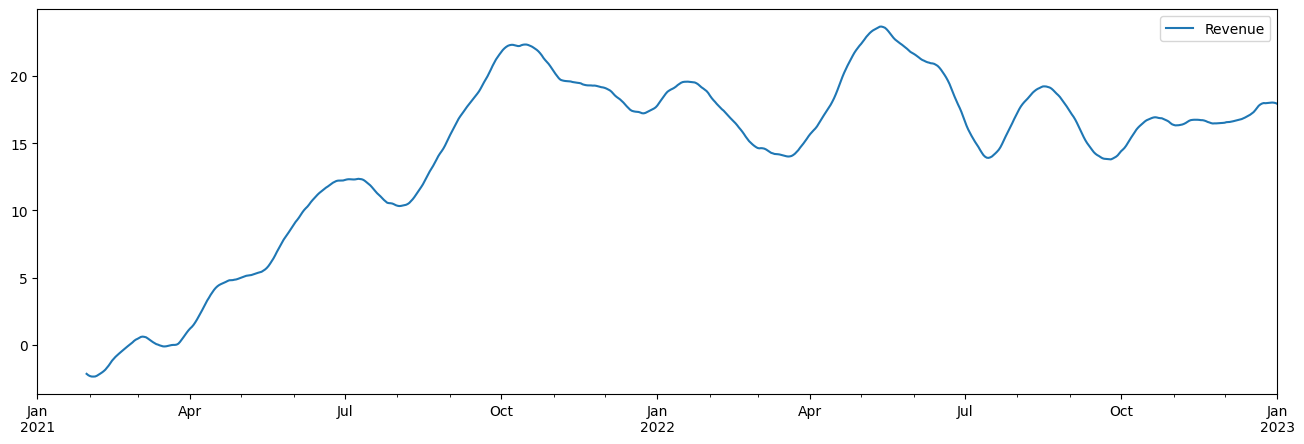

In [17]:
'''
Visually Plot Rolling Average
'''
def generate_rolling_plot(data: pd.DataFrame, window_size: int = 24) -> None:
    """
    :param data: data to performing rolling average on
    :type data: pd.DataFrame
    
    :param window_size:  number of months for the rolling average window size
    :type: window_size: int
    
    :return: None
    
    Documentation: 
        * Rolling - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html
        * Mean - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html
    """
    rolling = data.rolling(window=window_size)
    rolling_means = rolling.mean()
    rolling_means.plot(figsize=(16,5))
    
generate_rolling_plot(medical_daily_revenue)

Visually checking the Rolling Average it's pretty clear that the data is not stationary. To confirm this in a statistical manner we will now do the  [`Augmented Dickey-Fuller test`](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). 

In [18]:
'''
Augmented Dickey-Fuller Documentation: 
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

statsmodels.tsa.stattools.adfuller(
    x, 
    maxlag=None, 
    regression='c', 
    autolag='AIC', 
    store=False, 
    regresults=False
)
'''

def execute_adfuller(data: pd.Series, title: str) -> None:
    adf, p_value, used_lag, nobs, critical_values, icbest = adfuller(data)
    
    print(f'ADF Statistic: {adf}')
    print(f'p-value: {p_value}')
    print(f'Number of lags used: {used_lag}')
    print(f'Number of observations: {nobs}')
    print(f'Critical Values: {critical_values}')
    print(f'Maximized Information Criterion: {icbest}')
    
    print('\n')
    print('p-value Stationary Results:')
    print('=============================================================')
    is_data_stationary = p_value <= .05
    
    print(f'p-value check: {round(p_value, 4)} < .05')
    if is_data_stationary:
        print(f'{title} Time Series data is likely stationary.')
        print(f'Reject the null hypothesis (stationary) ')
    else:
        print(f'{title} Time Series data is likely non-stationary.')
        print(f'Fail to reject the null hypothesis (accept Alternative Hypothesis)')
    print('=============================================================')
    
    print('\n')
    print('adf (test statistic) Results:')
    print('=============================================================')
    
    print(f"adf check (1%): {round(adf, 4)} < {round(critical_values['1%'], 4)}")
    print(f"adf check (5%): {round(adf, 4)} < {round(critical_values['5%'], 4)}")
    print(f"adf check (10%): {round(adf, 4)} < {round(critical_values['10%'], 4)}")
    
    if adf < critical_values['1%']:
        print(f'{title} Time Series data is stationary at 1% significance level.')
    elif adf < critical_values['5%']:    
        print(f'{title} Time Series data is stationary at 5% significance level.')
    elif adf < critical_values['10%']:
        print(f'{title} Time Series data is stationary at 10% significance level.')
    else:
        print(f'{title} Time Series data is likely non-stationary.')

execute_adfuller(medical_daily_revenue['Revenue'], 'WGU Revenue')


ADF Statistic: -2.2183190476089454
p-value: 0.19966400615064356
Number of lags used: 1
Number of observations: 729
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Maximized Information Criterion: 842.453027617641


p-value Stationary Results:
p-value check: 0.1997 < .05
WGU Revenue Time Series data is likely non-stationary.
Fail to reject the null hypothesis (accept Alternative Hypothesis)


adf (test statistic) Results:
adf check (1%): -2.2183 < -3.4394
adf check (5%): -2.2183 < -2.8655
adf check (10%): -2.2183 < -2.5689
WGU Revenue Time Series data is likely non-stationary.


<a id="data-preparation"></a>
## C4: Data Preparation & Explanation

Time Series Analysis will require a little bit of data prepping. After preparing the data will also be split into training and testing data, so we can validate how well the model for the Time Series is performing.

Steps:

 1. Transform `Revenue` data into a stationary time series format by getting 'First discrete difference' of object using the [`.diff()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html) function of [`Pandas`](https://pandas.pydata.org/).
    *  Stabilizes the mean and moves data to stationary
 2. Removing missing values after transformation 
 3. Split transformed data into training and test datasets with an 80%/20% split. 

In [19]:
'''
Use diff() function to get the Discrete Differences and then perform .dropna() to remove missing values.
'''

discrete_differences = medical_daily_revenue.diff()

#drop the first row that tends to be empty
discrete_differences = discrete_differences.dropna()

revenue_discrete_differences = discrete_differences['Revenue']

execute_adfuller(revenue_discrete_differences, 'Transformed WGU Revenue')

ADF Statistic: -17.374772303557066
p-value: 5.113206978840171e-30
Number of lags used: 0
Number of observations: 729
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
Maximized Information Criterion: 846.2604386450553


p-value Stationary Results:
p-value check: 0.0 < .05
Transformed WGU Revenue Time Series data is likely stationary.
Reject the null hypothesis (stationary) 


adf (test statistic) Results:
adf check (1%): -17.3748 < -3.4394
adf check (5%): -17.3748 < -2.8655
adf check (10%): -17.3748 < -2.5689
Transformed WGU Revenue Time Series data is stationary at 1% significance level.


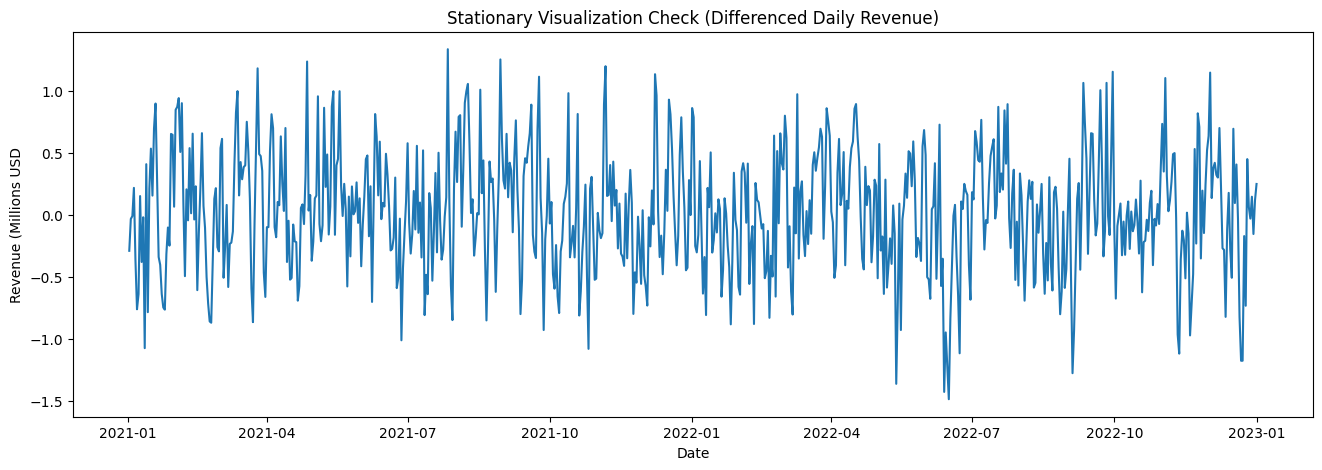

In [20]:
'''
Visual Check that Revenue Data is now Stationary
'''

plt.figure(figsize=(16,5))
plt.xlabel('Date')
plt.ylabel('Revenue (Millions USD')
plt.title('Stationary Visualization Check (Differenced Daily Revenue)')

plt.plot(discrete_differences)

This chart does not show any signs of trending or seasonality. The visual check confirms the p-value and adf value check of stationary.

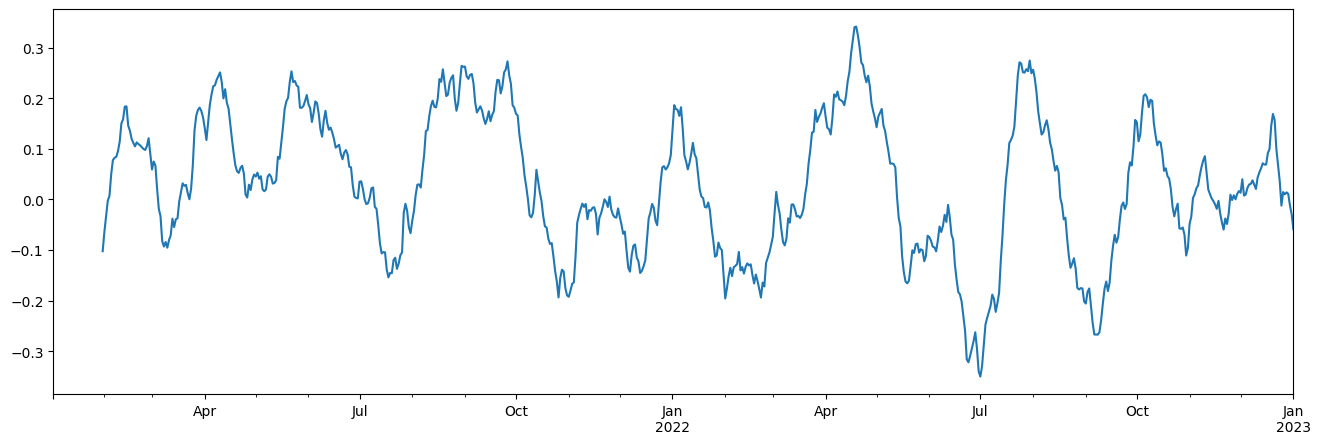

In [21]:
'''
Visually Plot Rolling Average of the Data Differences
'''

generate_rolling_plot(revenue_discrete_differences)


In [22]:
'''
Train and Test data splitting 80/20.
'''

train_data, test_data = train_test_split(discrete_differences, test_size=.2, shuffle=False, random_state=999)

print(train_data.head())
print(test_data.head())

             Revenue
2021-01-02 -0.292356
2021-01-03 -0.035416
2021-01-04 -0.012215
2021-01-05  0.215100
2021-01-06 -0.366702
             Revenue
2022-08-09  0.263991
2022-08-10 -0.588690
2022-08-11 -0.550427
2022-08-12  0.081477
2022-08-13 -0.146587


<a id="copy-of-prepared-data"></a>
## C5: Copy of Prepared Data Set

In [23]:
'''Saving Training Data'''
train_data.to_csv('./time-series-training-data.csv')

'''Saving Test Data'''
test_data.to_csv('./time-series-testing-data.csv')


# Part IV: Model Identification & Analysis

<a id="annotated-findings-and-visualizations"></a>
## D1: Annotated Findings & Visualizations

Annotating the findings and supplying visualizations with those findings is going to include two processes:

 * [`auto_arima`](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)
    * **Purpose:** Forecasting
    * Automatically discover the optimal order for an ARIMA model
    * Uses SARIMAX Modeling
 * [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)
    * **Purpose:** Exploration / Decomposition
    * Seasonal decomposition using moving averages.

In [24]:
'''
Auto Generate the Optimal Order for an ARIMA Model

Will be using Trace
trace : bool or int, optional (default=False)
    Whether to print status on the fits. A value of False will print no debugging information. A value of True will print some. Integer values exceeding 1 will print increasing amounts of debug information at each fit.
'''

auto_arima_results = auto_arima(revenue_discrete_differences)
print(auto_arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  730
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -437.991
Date:                Thu, 28 Sep 2023   AIC                            879.982
Time:                        12:29:48   BIC                            889.168
Sample:                    01-02-2021   HQIC                           883.526
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4142      0.034     12.258      0.000       0.348       0.480
sigma2         0.1943      0.011     17.842      0.000       0.173       0.216
Ljung-Box (L1) (Q):                   0.02   Jarque-

The [`WGU Medical Time Series Dataset`](https://access.wgu.edu/ASP3/aap/content/fj30d8sm59fc83ed9xsi.zip) being processed through the `auto_arima` process concluded these results:

Optimal **ARIMA (AutoRegressive Integrated Moving Average) Model** parameters:

| Component           | Parameter                | Optimal Value | Meaning                                                       |
|---------------------|--------------------------|---------------|---------------------------------------------------------------|
| AR (AutoRegressive) | p (Autoregressive Order) | 1             | Use 'First Lagged Value'                                      |
| I (Integrated)      | d (Differencing Order)   | 0             | Data is stationary, directly models original time-series data |
| MA (Moving Average) | q (Moving Average Order) | 0             | Will not use past forecast errors to model time-series        |


<a id="arima-model-of-time-series-data"></a>
## D2: ARIMA Model of Time Series Data

<a id="forcast"></a>
## D3: Forecast

<a id="analysis"></a>
## D4: Analysis Output & Calculations

<a id="arima-code"></a>
## D5: ARIMA Model Code

# Part V: Data Summary and Implications

<a id="results-of-analysis"></a>
## E1: Results of Analysis

<a id="forcast-visualizations"></a>
## E2: Visualization of Forecast

<a id="recommendations"></a>
## E3: Recommended Action

<a id="reporting"></a>
## F: Reporting

<a id="code-references"></a>
## G: Code References

<a id="source-references"></a>
## H: Source References

 * Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. <br /><br />
 * Prabhakaran, S. (2022). Augmented Dickey Fuller Test (ADF Test) – must read guide. Machine Learning Plus. https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/ 